<a href="https://colab.research.google.com/github/HR0262/PCMCI-in-commuter-trian/blob/main/Lyapunov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

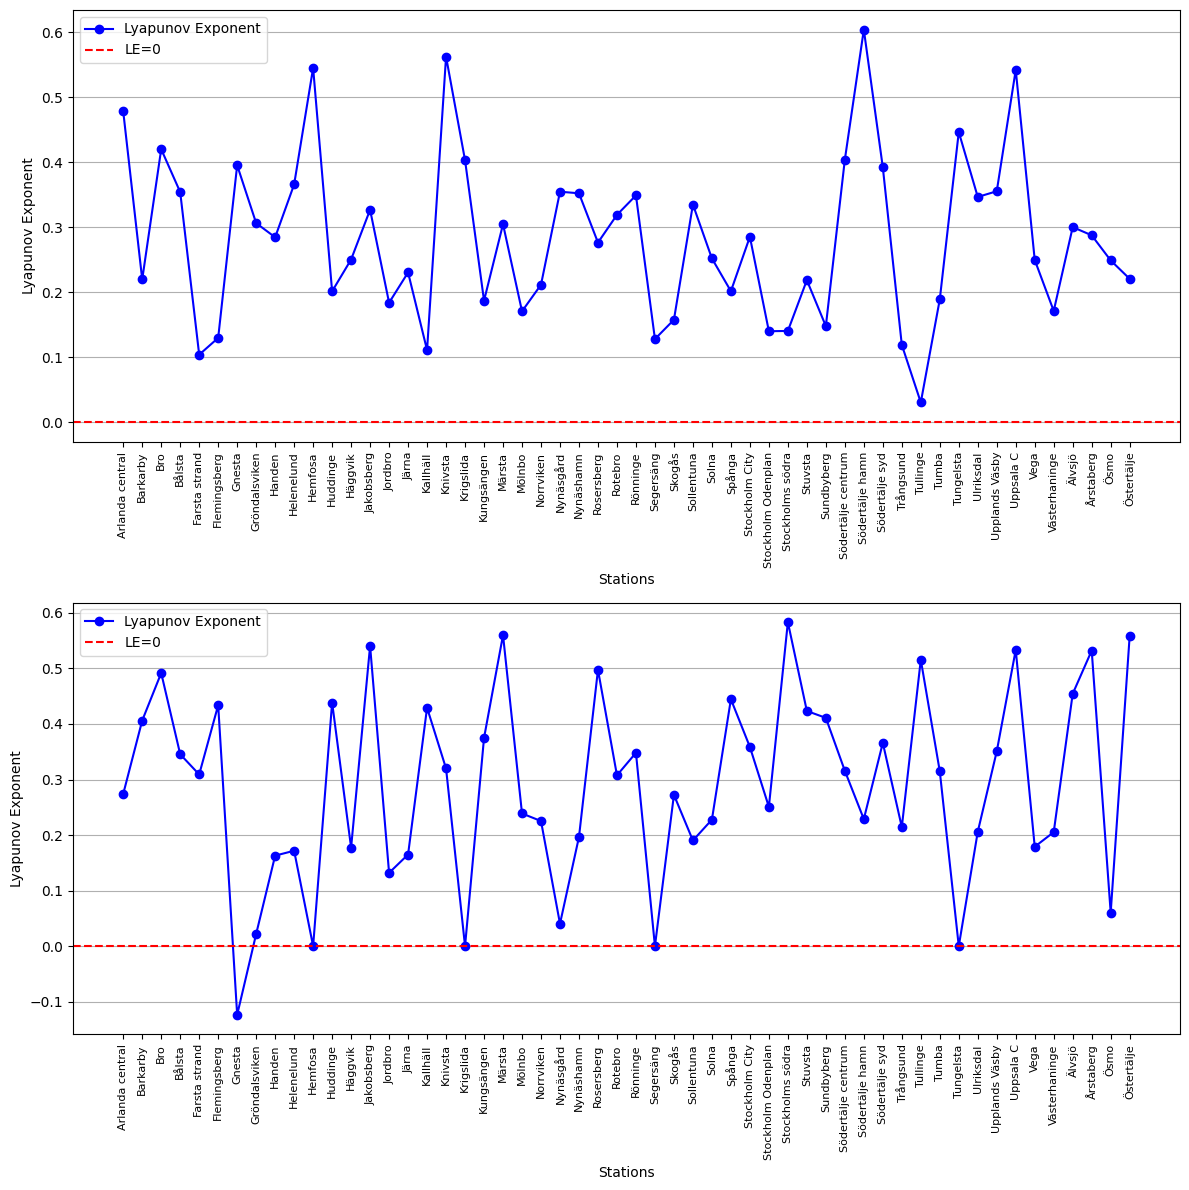

In [8]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# 1. 读取CSV数据
def load_data(file_path):
    df = pd.read_csv(file_path)
    # print(f"Columns in {file_path}: {df.columns.tolist()}") # Commented out print
    # Dynamically determine the time bin column name
    if 'time_bin' in df.columns:
        time_col = 'time_bin'
    elif 'hour_bin' in df.columns:
        time_col = 'hour_bin'
    else:
        raise ValueError(f"Could not find time bin column in {file_path}. Expected 'time_bin' or 'hour_bin'.")

    time_bins = df[time_col].values
    stations = df.drop(columns=[time_col]).columns
    data = df.drop(columns=[time_col]).values
    return time_bins, stations, data

# 2. 相空间重构
def phase_space_reconstruction(series, m, tau):
    n = len(series)
    M = n - (m - 1) * tau
    if M <= 0:
        return None
    X = np.zeros((M, m))
    for i in range(M):
        for j in range(m):
            X[i, j] = series[i + j * tau]
    return X

# 3. 找到最近邻点
def find_nearest_neighbor(X, idx, min_time_separation):
    min_dist = float('inf')
    nn_idx = -1
    for i in range(len(X)):
        if abs(i - idx) > min_time_separation:
            dist = euclidean(X[idx], X[i])
            if dist < min_dist and dist > 0:
                min_dist = dist
                nn_idx = i
    return nn_idx, min_dist

# 4. 计算Lyapunov指数
def lyapunov_exponent(series, m=3, tau=1, min_time_separation=5, max_iter=10):
    series = series[~np.isnan(series)]
    if len(series) < (m - 1) * tau + max_iter:
        return np.nan
    X = phase_space_reconstruction(series, m, tau)
    if X is None:
        return np.nan
    divergence = []
    for i in range(len(X)):
        nn_idx, initial_dist = find_nearest_neighbor(X, i, min_time_separation)
        if nn_idx == -1:
            continue
        for t in range(1, min(max_iter, len(X) - max(i, nn_idx))):
            dist_t = euclidean(X[i + t], X[nn_idx + t])
            if dist_t > 0:
                divergence.append(np.log(dist_t / initial_dist) / t)
    if not divergence:
        return np.nan
    return np.mean(divergence)

# 5. 主函数：处理所有站点的Lyapunov指数并绘制折线图
def compute_lyapunov_for_stations_and_plot(file_paths):
    # Create subplots
    fig, axes = plt.subplots(len(file_paths), 1, figsize=(12, 6 * len(file_paths)))

    all_results = {}

    for i, file_path in enumerate(file_paths):
        # 加载数据
        time_bins, stations, data = load_data(file_path)

        # 存储结果
        results = {}

        # 对每个站点计算Lyapunov指数
        for idx, station in enumerate(stations):
            series = data[:, idx]
            if np.all(series == 0) or np.all(np.isnan(series)):
                results[station] = np.nan
                continue
            lyap_exp = lyapunov_exponent(series, m=3, tau=1, min_time_separation=5, max_iter=10)
            results[station] = lyap_exp
            # print(f"Station: {station}, Lyapunov Exponent: {lyap_exp:.4f}") # Commented out print

        all_results[file_path] = results

        # 筛选有效结果
        valid_stations = [k for k, v in results.items() if not np.isnan(v)]
        valid_lyap = [v for v in results.values() if not np.isnan(v)]

        # 绘制折线图
        axes[i].plot(range(len(valid_stations)), valid_lyap, marker='o', linestyle='-', color='b', label='Lyapunov Exponent')
        axes[i].axhline(y=0, color='r', linestyle='--', label='LE=0')
        axes[i].set_xlabel('Stations')  # x轴名称
        axes[i].set_ylabel('Lyapunov Exponent')
        # axes[i].set_title(f'Lyapunov Exponents for Stockholm Commuter Rail Stations ({file_path})')
        axes[i].set_xticks(range(len(valid_stations))) # Set ticks for station names
        axes[i].set_xticklabels(valid_stations, rotation=90)  # Add station names as x-axis labels
        axes[i].legend(loc='upper left') # Set legend location to upper left
        axes[i].grid(axis='y', linestyle='-') # Keep horizontal grid lines
        axes[i].tick_params(axis='x', labelsize=8) # Adjust label size for better readability

    plt.tight_layout()
    plt.show()

    return all_results

# 6. 运行代码
file_paths = ['0427_delaymean_None_300600_15.csv', '0404_delaymean_None_1621_15.csv'] # List of file paths
results = compute_lyapunov_for_stations_and_plot(file_paths)

# 7. 判断非线性
# for file_path, station_results in results.items(): # Commented out print
#     print(f"\nAnalysis for {file_path}:") # Commented out print
#     for station, lyap_exp in station_results.items(): # Commented out print
#         if np.isnan(lyap_exp): # Commented out print
#             continue # Commented out print
#         if lyap_exp > 0: # Commented out print
#             print(f"{station}: Positive Lyapunov Exponent ({lyap_exp:.4f}) -> Likely Nonlinear/Chaotic") # Commented out print
#         elif lyap_exp < 0: # Commented out print
#             print(f"{station}: Negative Lyapunov Exponent ({lyap_exp:.4f}) -> Likely Stable") # Commented out print
#         else: # Commented out print
#             print(f"{station}: Lyapunov Exponent ~0 ({lyap_exp:.4f}) -> Likely Periodic/Quasi-periodic") # Commented out print